### LIBRERIAS

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, lfilter
from scipy import signal
import pandas as pd
from sklearn.cross_decomposition import CCA
from os import listdir
from os.path import isfile, join

### BASE DE DATOS DE SSVEP

In [2]:
DB_path = "../DB/"
DBfiles = [f for f in listdir(DB_path) if isfile(join(DB_path, f))]
DBfiles = DBfiles[2:]


### FUNCIONES

In [105]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter_all(data, freqs, fs, order=5):
    data_filtered = []
    for index in np.arange(len(data)):
        freq = freqs[index]
        b, a = butter_bandpass(freq-3, 2*freq+4, fs, order=order)
        y = lfilter(b,a,data[index])
        data_filtered.append(y)
    return data_filtered

def notch_filter(data):
    samp_freq = sr  
    notch_freq = 50.0 
    quality_factor = 20.0  
    
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
    outputSignal = signal.filtfilt(b_notch, a_notch, data)
    return outputSignal

def avg_signal(signal):
    avg_signal = np.zeros(signal.shape[0])                             
    iter = signal.shape[1]
    for col in np.arange(iter):
        avg_signal += signal[:,col]
    return avg_signal/iter

def avg_all_signals(signals):
    avg_signals = []
    for index in np.arange(len(signals)):
        avg_signals.append(np.zeros(1500))
    iter = signals[0].shape[1]
    for signal in np.arange(len(signals)):
        for block in np.arange(iter):
            avg_signals[signal] += signals[signal][:,block]
        avg_signals[signal] = avg_signals[signal]/iter
    return avg_signals

def drop_trash_data(data, avoid_data):
    return data[avoid_data:data.size-avoid_data:] 

def drop_all_trash_data(data, avoid_data):
    data_without_trash = []
    for index in np.arange(len(data)):
        temp = data[index]
        temp = temp[avoid_data:temp.size-avoid_data:] 
        data_without_trash.append(temp)
    return data_without_trash

def get_data(data, electrode, freq):
    freq = str(freq) + ".0"
    elec = int(electrodes[electrode])-1
    frec = stimulation[freq]
    return data[elec,:,frec,:]

def get_all_data(data, electrode, freqs):
    datas = []
    elec = int(electrodes[electrode])-1
    for index in np.arange(len(freqs)):
        freq_temp = stimulation[str(freqs[index]) + ".0"]
        data_temp = data[elec,:,freq_temp,:]
        datas.append(data_temp)
    return datas

def plot_time_signals(raw_data, filtered_data):
    fig, ax = plt.subplots(2,figsize=(35,10))
    ax[0].plot(time_steps,raw_data)
    ax[0].set_title("Raw Signal")
    ax[1].plot(time_steps,filtered_data)
    ax[1].set_title("Filtered Signal")
    plt.show()

def plot_all_time(filtered_data,time_axis, freqs):
    fig, ax = plt.subplots(2,2,figsize=(30,8))
    for i in np.arange(len(filtered_data)):
        if i<2:
            ax[0,i].plot(time_axis, filtered_data[i])
            ax[0,i].set_title(f'Señal de {str(freqs[i])} Hz')
            ax[0,i].grid()
        else:
            ax[1,i-2].plot(time_axis, filtered_data[i])
            ax[1,i-2].set_title(f'Señal de {str(freqs[i])} Hz')
            ax[1,i-2].grid()
    plt.show()

def plot_fft_signals(raw_data, filtered_data, notch_filtered_data):
    x = fft(raw_data)
    x1 = fft(filtered_data)
    x2 = fft(notch_filtered_data)
    N = len(x)
    n = np.arange(N)
    sample_rate = sr
    T = N/sample_rate
    freq = n/T 
    n_oneside = N//2
    f_oneside = freq[:n_oneside]
    fig, ax = plt.subplots(3,figsize=(30,15))
    ax[0].plot(f_oneside, np.abs(x[:n_oneside]))
    ax[0].set_title("Raw Signal")
    ax[0].set_xticks(np.arange(min(f_oneside), max(f_oneside)+1, 1.0))
    ax[0].grid()
    ax[1].plot(f_oneside, np.abs(x1[:n_oneside]))
    ax[1].set_title("Filtered Signal")
    ax[1].set_xticks(np.arange(min(f_oneside), max(f_oneside)+1, 1.0))
    ax[1].grid()
    ax[2].plot(f_oneside, np.abs(x2[:n_oneside]))
    ax[2].set_title("Notch Filtered Signal")
    ax[2].set_xticks(np.arange(min(f_oneside), max(f_oneside)+1, 1.0))
    ax[2].grid()
    plt.show()

def plot_all_ffts(filtered_data, freqs, sr):
    x = fft(filtered_data[0])
    N = len(x)
    n = np.arange(N)
    sample_rate = sr
    T = N/sample_rate
    freq = n/T 
    n_oneside = N//2
    f_oneside = freq[:n_oneside]
    fig, ax = plt.subplots(2,2,figsize=(30,8))
    for i in np.arange(len(filtered_data)):
        x = fft(filtered_data[i])
        if i<2:
            ax[0,i].plot(f_oneside, np.abs(x[:n_oneside]))
            ax[0,i].set_title(f'Señal de {str(freqs[i])} Hz')
            ax[0,i].set_xticks(np.arange(min(f_oneside), max(f_oneside)+1, 2.0))
            ax[0,i].set_xlim([0,60])
            ax[0,i].grid()
        else:
            ax[1,i-2].plot(f_oneside, np.abs(x[:n_oneside]))
            ax[1,i-2].set_title(f'Señal de {str(freqs[i])} Hz')
            ax[1,i-2].set_xticks(np.arange(min(f_oneside), max(f_oneside)+1, 2.0))
            ax[1,i-2].set_xlim([0,60])
            ax[1,i-2].grid()

    plt.show()
    

### ELECTRODOS INDEX

In [4]:
#DICCIONARIO DE INDICES DE ELECTRODOS

def remove_whitespace(s):
    return s.strip()

df = pd.read_csv('../DB/electrodo_index.csv', header=None,sep='\t')
df[3] = df[3].astype(str)
df[3] = df[3].apply(remove_whitespace)
df[3] = df[3].replace('nan','PO5')
df[0] = df[0].replace('54      -144', '54')

electrode_name = np.array(df[3])
electrode_index = np.array(df[0])
electrodes = dict(zip(electrode_name,electrode_index))
electrodes

{'FP1': '1',
 'FPZ': '2',
 'FP2': '3',
 'AF3': '4',
 'AF4': '5',
 'F7': '6',
 'F5': '7',
 'F3': '8',
 'F1': '9',
 'FZ': '10',
 'F2': '11',
 'F4': '12',
 'F6': '13',
 'F8': '14',
 'FT7': '15',
 'FC5': '16',
 'FC3': '17',
 'FC1': '18',
 'FCz': '19',
 'FC2': '20',
 'FC4': '21',
 'FC6': '22',
 'FT8': '23',
 'T7': '24',
 'C5': '25',
 'C3': '26',
 'C1': '27',
 'Cz': '28',
 'C2': '29',
 'C4': '30',
 'C6': '31',
 'T8': '32',
 'M1': '33',
 'TP7': '34',
 'CP5': '35',
 'CP3': '36',
 'CP1': '37',
 'CPZ': '38',
 'CP2': '39',
 'CP4': '40',
 'CP6': '41',
 'TP8': '42',
 'M2': '43',
 'P7': '44',
 'P5': '45',
 'P3': '46',
 'P1': '47',
 'PZ': '48',
 'P2': '49',
 'P4': '50',
 'P6': '51',
 'P8': '52',
 'PO7': '53',
 'PO5': '54',
 'PO3': '55',
 'POz': '56',
 'PO4': '57',
 'PO6': '58',
 'PO8': '59',
 'CB1': '60',
 'O1': '61',
 'Oz': '62',
 'O2': '63',
 'CB2': '64'}

### FRECUENCIAS DE ESTIMULOS

In [5]:
#DICCIONARIO DE LAS FRECUENCIAS DE ESTIMULACIONES

freqs = scipy.io.loadmat('../DB/Freq_Phase.mat')
freqs = freqs['freqs'][0,:].astype(str)
stimulation = dict(zip(freqs,np.arange(len(freqs))))
stimulation


{'8.0': 0,
 '9.0': 1,
 '10.0': 2,
 '11.0': 3,
 '12.0': 4,
 '13.0': 5,
 '14.0': 6,
 '15.0': 7,
 '8.2': 8,
 '9.2': 9,
 '10.2': 10,
 '11.2': 11,
 '12.200000000000001': 12,
 '13.200000000000001': 13,
 '14.200000000000001': 14,
 '15.200000000000001': 15,
 '8.4': 16,
 '9.4': 17,
 '10.4': 18,
 '11.4': 19,
 '12.4': 20,
 '13.4': 21,
 '14.4': 22,
 '15.4': 23,
 '8.6': 24,
 '9.6': 25,
 '10.6': 26,
 '11.6': 27,
 '12.600000000000001': 28,
 '13.600000000000001': 29,
 '14.600000000000001': 30,
 '15.600000000000001': 31,
 '8.8': 32,
 '9.8': 33,
 '10.8': 34,
 '11.8': 35,
 '12.8': 36,
 '13.8': 37,
 '14.8': 38,
 '15.8': 39}

### DATA(ELECTRODO, DATOS, FRECUENCIA, BLOQUE)

In [6]:
people = []

for index in np.arange(len(DBfiles)):
    temp = scipy.io.loadmat('../DB/'+DBfiles[index])
    people.append(np.array(temp['data']))

In [16]:
sr = 250
avoid_time = 0.5
trash_data = int(avoid_time*sr)

In [158]:
freq = 8
S1_OZ = get_data(people[0],'Oz',freq)

In [172]:
freqs = [8,10,12,14]
P4_OZ = get_all_data(people[1],'Oz',freqs)

### PROMEDIO DE SEÑAL Y ELIMINACION DE RUIDO

In [33]:
S1_OZ_15Hz_AVG = avg_signal(S1_OZ)

S1_OZ_15Hz_AVG_5sec = drop_trash_data(S1_OZ_15Hz_AVG,trash_data)

In [173]:
P4_OZ_AVG = avg_all_signals(P4_OZ)
P4_OZ_AVG_WT= drop_all_trash_data(P4_OZ_AVG, trash_data)

### FILTRADO DE SEÑAL

In [55]:
#PROCESO DE FILTRADO

filtered = bandpass_filter(data=S1_OZ_15Hz_AVG_5sec,lowcut=freq-3,highcut=2*freq+4,fs=sr, order=9)

filtered_with_notch = notch_filter(filtered)


In [174]:
P4_OZ_AVG_WT_F = bandpass_filter_all(P4_OZ_AVG_WT,freqs=freqs,fs=sr,order=9)

### PLOT DE SEÑAL EN TIEMPO

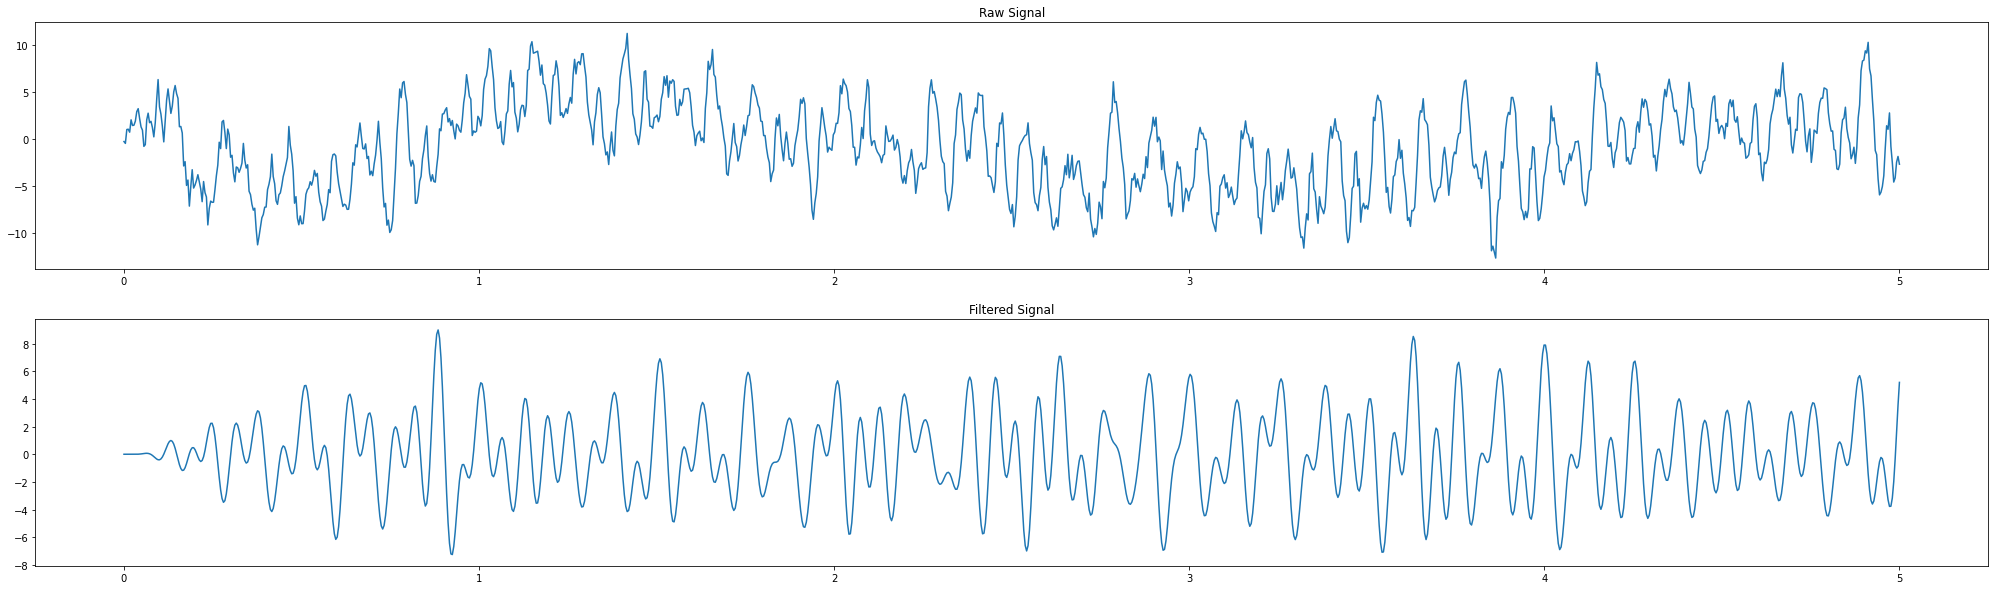

In [56]:
max_time = len(S1_OZ_15Hz_AVG_5sec)/sr
time_steps = np.linspace(0, max_time, len(S1_OZ_15Hz_AVG_5sec))

plot_time_signals(S1_OZ_15Hz_AVG_5sec, filtered)

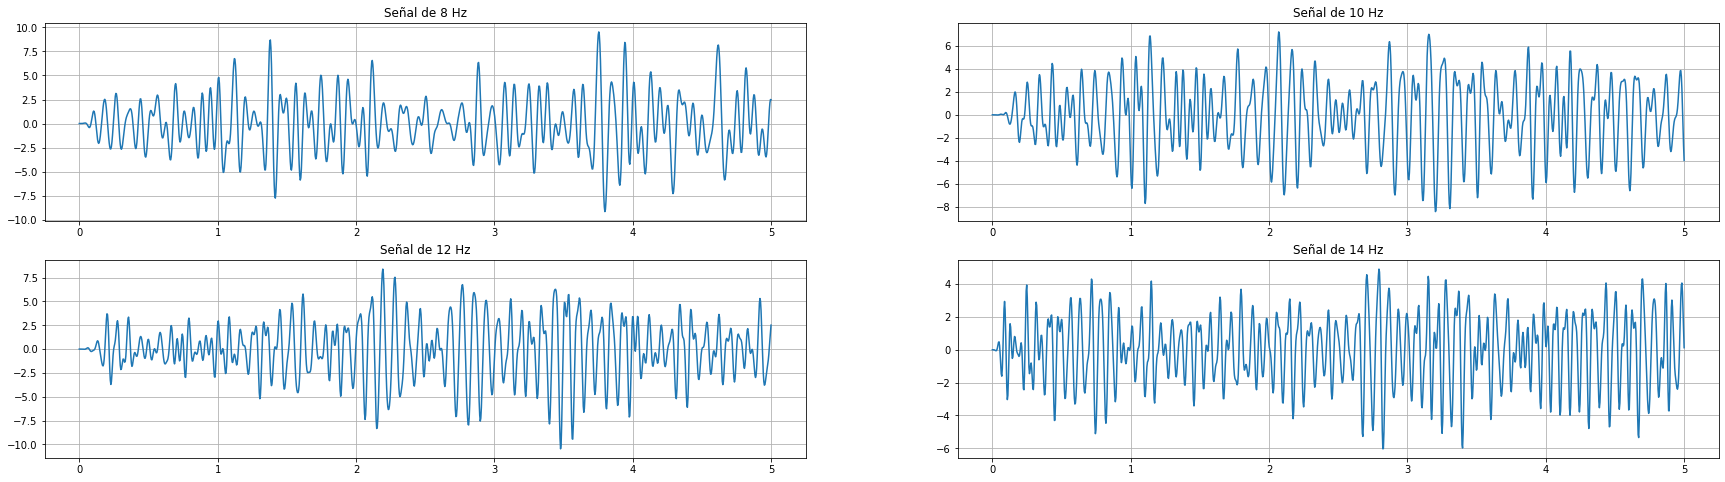

In [163]:
max_time = len(P4_OZ_AVG_WT_F[0])/sr
time_steps = np.linspace(0, max_time, len(P4_OZ_AVG_WT_F[0]))

plot_all_time(P4_OZ_AVG_WT_F,time_steps,freqs)

### PLOT DE SEÑAL EN FRECUENCIA

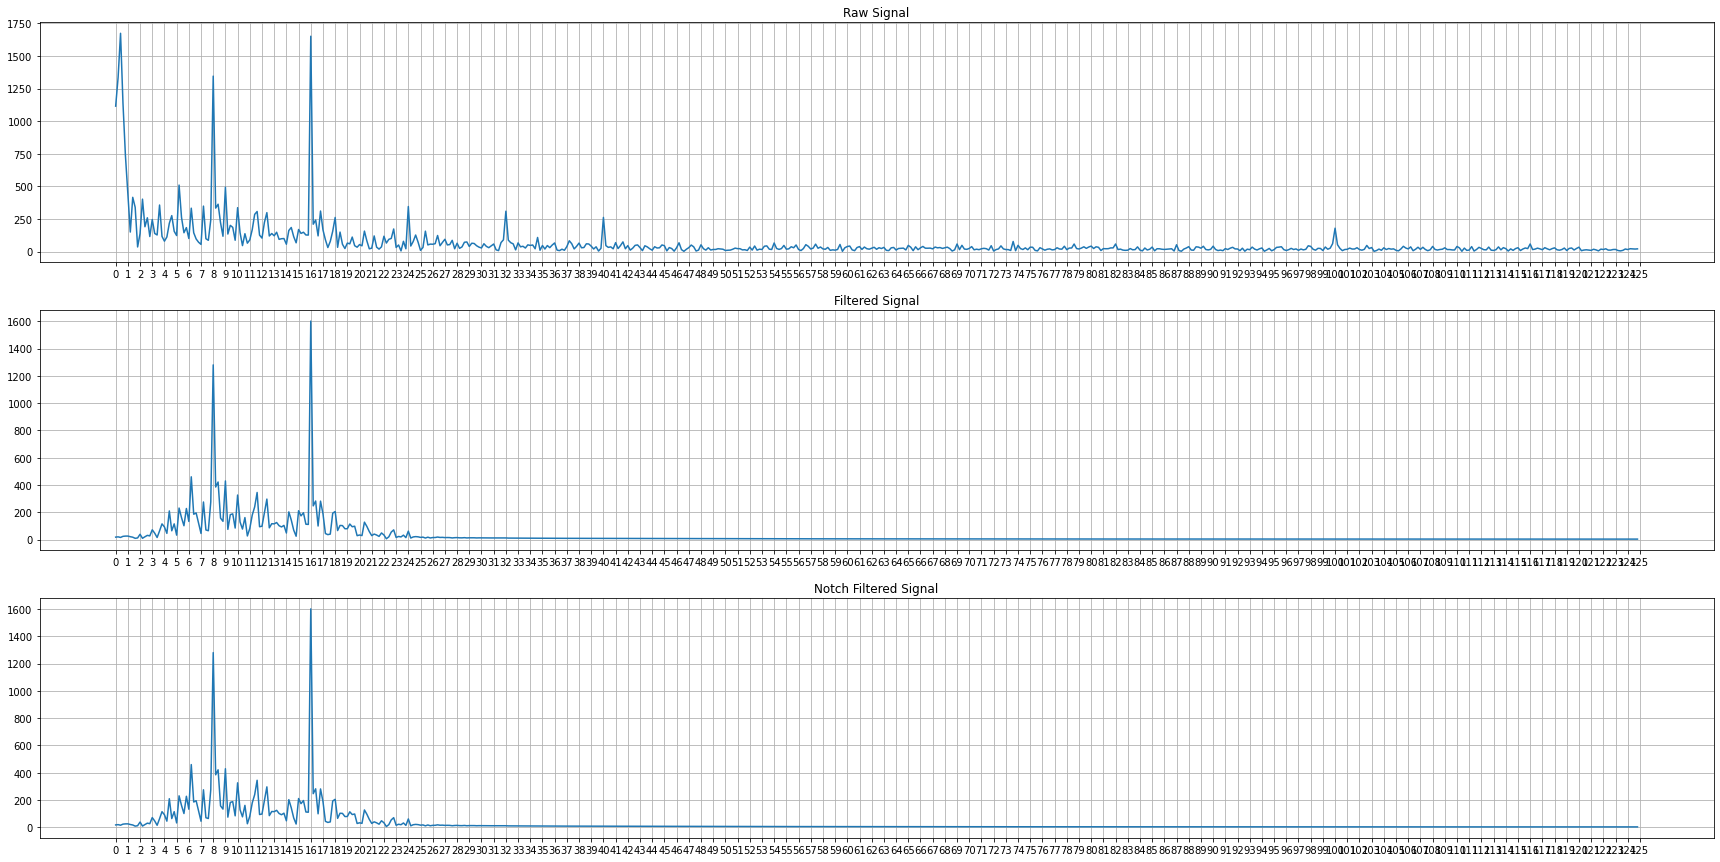

In [53]:
plot_fft_signals(S1_OZ_15Hz_AVG_5sec,filtered, filtered_with_notch)

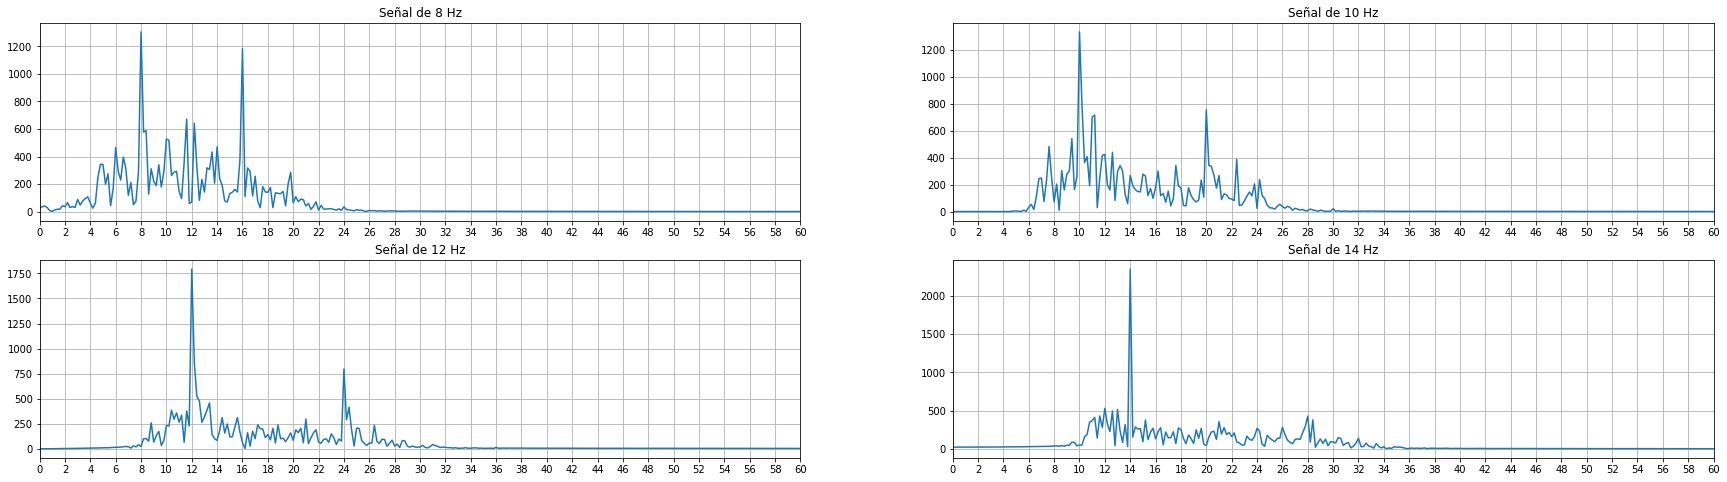

In [175]:
plot_all_ffts(P4_OZ_AVG_WT_F,freqs,sr=sr)

### SEÑALES MODELO

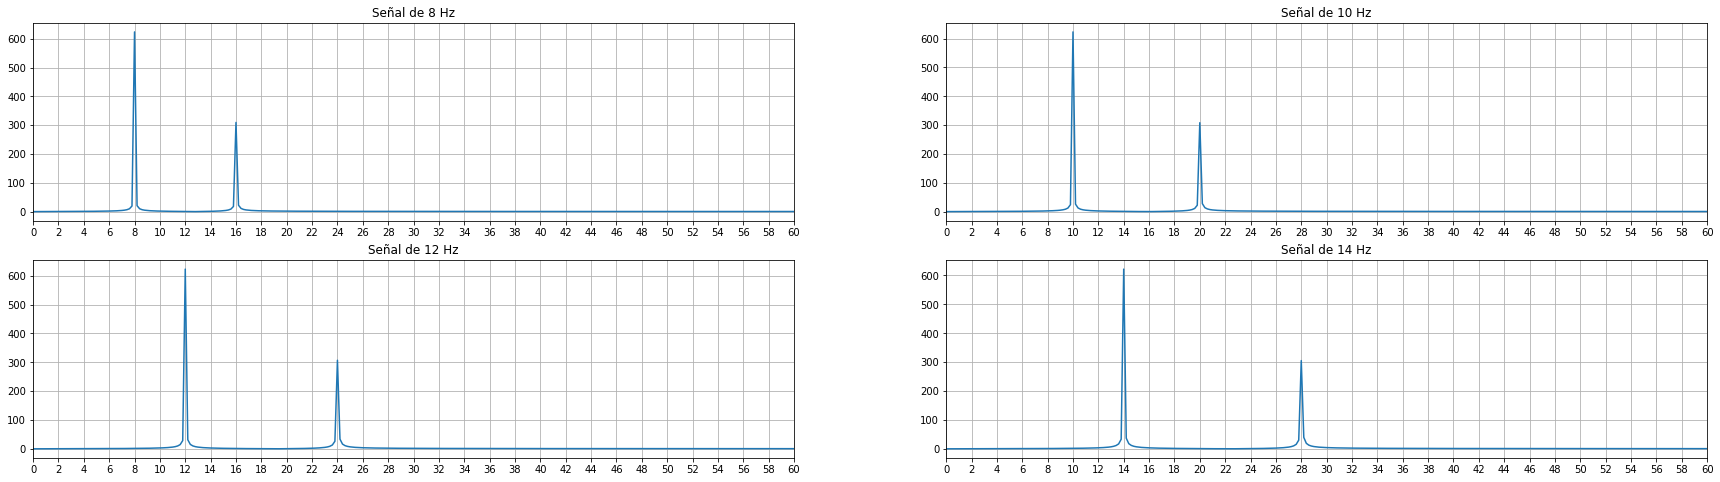

In [13]:
a1 = 1.0
a2 = 0.5

#FRECUENCIA DE LAS SEÑALES
target_freqs = [8,10,12,14]

reference_signals = []
reference_ffts = []

for index in np.arange(len(target_freqs)):
    model_signal = a1*np.sin(np.pi*2*time_steps*target_freqs[index]) + a2*np.sin(np.pi*4*time_steps*target_freqs[index])
    reference_signals.append(model_signal)
    reference_ffts.append(fft(model_signal))

N = len(reference_ffts[0])
n = np.arange(N)
T = N/sr
freq = n/T 
n_oneside = N//2
f_oneside = freq[:n_oneside]

fig, ax = plt.subplots(2,2,figsize=(30,8))

for i in np.arange(len(target_freqs)):
    if i<2:
        ax[0,i].plot(f_oneside, np.abs(reference_ffts[i][:n_oneside]))
        ax[0,i].set_title(f'Señal de {str(target_freqs[i])} Hz')
        ax[0,i].set_xticks(np.arange(min(f_oneside), max(f_oneside)+1, 2.0))
        ax[0,i].set_xlim([0,60])
        ax[0,i].grid()
    else:
        ax[1,i-2].plot(f_oneside, np.abs(reference_ffts[i][:n_oneside]))
        ax[1,i-2].set_title(f'Señal de {str(target_freqs[i])} Hz')
        ax[1,i-2].set_xticks(np.arange(min(f_oneside), max(f_oneside)+1, 2.0))
        ax[1,i-2].set_xlim([0,60])
        ax[1,i-2].grid()

plt.show()

### ALGORITMO CCA

In [14]:
def get_corr(EEG_signal, model_signals):
    EEG_signal_temp = EEG_signal.reshape(-1,1)
    cca = CCA(n_components=1)
    results = dict(zip(target_freqs,np.zeros(len(model_signals))))

    for index in np.arange(len(model_signals)):
        model_signal_temp = model_signals[index].reshape(-1,1)
        cca.fit(EEG_signal_temp, model_signal_temp)
        O1_a,O1_b = cca.transform(EEG_signal_temp, model_signal_temp)
        results[target_freqs[index]] = np.corrcoef(O1_a[:,0],O1_b)[0,1]
    
    return results


In [168]:
def get_all_corr(signals, model_signals, freqs):
    results = dict(zip(freqs,np.zeros(len(model_signals))))
    cca = CCA(n_components=1)
    #result_signal = []
    for signal in np.arange(len(signals)):
        corr_signal = []
        temp_signal = signals[signal].reshape(-1,1)
        for index in np.arange(len(model_signals)):
            model_signal_temp = model_signals[index].reshape(-1,1)
            cca.fit(temp_signal,model_signal_temp)
            a,b = cca.transform(temp_signal,model_signal_temp)
            x = abs(np.corrcoef(a[:,0], b)[0,1])
            corr_signal.append(x)
        results[freqs[signal]] = corr_signal
    
    return results


In [154]:
def print_results(corr, freqs):
    for index in np.arange(len(corr)):
        max_index = np.argmax(corr[freqs[index]])
        print(f'Flicker: {freqs[index]} Hz - CCA: {freqs[max_index]} Hz')

In [169]:
res = get_corr(filtered, reference_signals)
res

{8: 0.17851093483908642,
 10: -0.11065355913885115,
 12: 0.026580124673146667,
 14: 0.008671792265598766}

In [179]:
r = get_all_corr(P4_OZ_AVG_WT_F, reference_signals, freqs=freqs)


In [178]:
print_results(r,freqs)

Flicker: 8 Hz - CCA: 8 Hz
Flicker: 10 Hz - CCA: 10 Hz
Flicker: 12 Hz - CCA: 12 Hz
Flicker: 14 Hz - CCA: 14 Hz
